In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians
from sympy import *
init_printing(use_latex='mathjax')

# Дороги в симуляторе

Дороги представлены в виде ломанных. Ломанные обеспечивают достаточную точность, нет необходимости усложнять и применять различные кривые Безье и прочее.

Дорогу надо не просто отрендерить, но и передать в каком-то виде в систему управления автомобилем. В качестве представления неподвижных препядствий выбран OccupancyGrid, потому что это просто и хорошо подходит для статических препятствий. Непонятно, как еще можно представить произвольное окружение. Поэтому для представления дороги в виде OccupancyGrid ее надо растрировать.

Для растрирования дороги применяется модифицированный алгоритм Брезенхэма для рисования линий с заданной толщины. Главная проблема - это соединение двух сегментов дороги под углом.

Угловое соединение между двумя сегментами дороги шириной $w$:
![](simulator_corner.png)

Необходимо найти координаты точек $A_2$, $B_2$, чтобы правильно растрировать угловое соединение сегментов. Точку $A_2$ найдем как точку пересечения прямых $A_1A_2$ и $O_2A_2$. Для этого составим канонические уравнения этих прямых.

$O_1O_2$, $O_2O_3$ - два соединяющихся сегмента дороги. $\vec{v}_1$, $\vec{v}_2$ - направляющие вектора этих сегментов. $\vec{n}_1$, $\vec{n}_2$ - вектора нормали к этим сегментам:
$$
\vec{n}_1 = \vec{v}_1 \times \vec{up} \\
\vec{n}_2 = \vec{v}_2 \times \vec{up}
$$
$
\begin{align*}
    \text{где } & up - \text{вектор, направленный вверх (0, 0, 1).}
\end{align*}
$

Координата точки $A_1$:
$$
\vec{A}_1 = \vec{O}_1 + \frac{\vec{n}_1}{\left\lVert \vec{n}_1 \right\rVert}\cdot \frac{w}{2}
$$

Каноническое уравнение прямой $A_1A_2$:
$$
\frac{x - A_{1x}}{\vec{v}_{1x}} = \frac{y - A_{1y}}{\vec{v}_{1y}}
$$

Каноническое уравнение прямой $O_2A_3$:
$$
\frac{x - O_{2x}}{\vec{n}_x} = \frac{y - O_{2y}}{\vec{n}_x}
$$


Составим систему уравнений и найдем из нее координату точки пересечения:
$$
\begin{cases}
    \frac{x - A_{1x}}{v_{1x}} = \frac{y - A_{1y}}{v_{1y}} \\
    \frac{x - O_{2x}}{\vec{n}_x} = \frac{y - O_{2y}}{\vec{n}_x}
\end{cases}
$$

Решим систему символьно:

In [2]:
x, y = symbols('x y')
nx, ny, vx, vy = symbols('nx ny vx vy')
Ax, Ay, Ox, Oy = symbols('Ax Ay Ox Oy')

e1 = (x - Ax)/vx - (y - Ay)/vy
e2 = (x - Ox)/nx - (y - Oy)/ny
res = solve([e1, e2], [x, y])


In [3]:
e1

  -Ay + y   -Ax + x
- ─────── + ───────
     vy        vx  

In [4]:
e2

  -Oy + y   -Ox + x
- ─────── + ───────
     ny        nx  

In [5]:
res

⎧   nx⋅(Ax⋅vy - Ay⋅vx) - vx⋅(Ox⋅ny - Oy⋅nx)     ny⋅(Ax⋅vy - Ay⋅vx) - vy⋅(Ox⋅ny
⎨x: ───────────────────────────────────────, y: ──────────────────────────────
⎩                nx⋅vy - ny⋅vx                               nx⋅vy - ny⋅vx    

 - Oy⋅nx)⎫
─────────⎬
         ⎭

In [6]:
# Для копипаста в питон:
for r in res:
    print(res[r])

(ny*(Ax*vy - Ay*vx) - vy*(Ox*ny - Oy*nx))/(nx*vy - ny*vx)
(nx*(Ax*vy - Ay*vx) - vx*(Ox*ny - Oy*nx))/(nx*vy - ny*vx)


### Расчет стыков сегментов

[32.  0.]
[28.  0.]


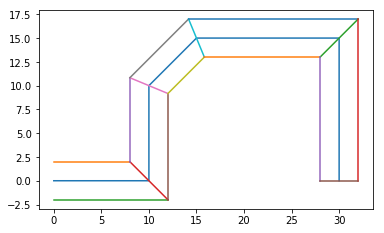

In [20]:
def draw_vec(P, vec, length):
    P1 = P + vec/np.linalg.norm(vec) * length
    coords = np.vstack([P, P1])
    plt.plot(coords[:,0], coords[:,1])

def draw_point(P):
    plt.plot([P[0]], [P[1]], 'o')
    
def draw_line(A, B):
    coords = np.vstack([A, B])
    plt.plot(coords[:,0], coords[:,1])

def draw_segment(A1, B1, A2, B2):
    draw_line(A1, A2)
    draw_line(B1, B2)
    draw_line(A2, B2)
    
def line_intersect(P1, v1, P2, v2):
    x = (v2[0]*(P1[0]*v1[1] - P1[1]*v1[0]) - v1[0]*(P2[0]*v2[1] - P2[1]*v2[0]))/(v2[0]*v1[1] - v2[1]*v1[0])
    y = (v2[1]*(P1[0]*v1[1] - P1[1]*v1[0]) - v1[1]*(P2[0]*v2[1] - P2[1]*v2[0]))/(v2[0]*v1[1] - v2[1]*v1[0])
    return np.array([x,y])

def normalize(vec):
    return vec/np.linalg.norm(vec)

points = np.array([
    [0,0],
    [10, 0],
    [10, 10],
    [15,15],
    [30, 15],
    [30, 0]
])

up = np.array([0,0,1])
w = 4

plt.plot(points[:,0], points[:,1])

v1 = normalize(points[1] - points[0])
n1 = np.cross(up, v1)[:2]
A1 = points[0] + n1 * w/2
B1 = points[0] - n1 * w/2

for i in range(len(points)-2):
    O1 = points[i]
    O2 = points[i+1]

    v2 = normalize(points[i+2] - points[i+1])
    n2 = np.cross(up, v2)[:2]
    n = (n1 + n2)/2

    A2 = line_intersect(A1, v1, O2, n)
    B2 = line_intersect(B1, v1, O2, -n)
    
    draw_segment(A1, B1, A2, B2)
    
    A1 = A2
    B1 = B2
    n1 = n2
    v1 = v2
    
A2 = points[-1] + n1 * w/2
B2 = points[-1] - n1 * w/2
draw_segment(A1, B1, A2, B2)
print(A2)
print(B2)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [130]:
data = np.zeros(4, dtype = [ ("position", np.float32, 3),
                                ("color",    np.float32, 4)] )
data

array([([0., 0., 0.], [0., 0., 0., 0.]), ([0., 0., 0.], [0., 0., 0., 0.]),
       ([0., 0., 0.], [0., 0., 0., 0.]), ([0., 0., 0.], [0., 0., 0., 0.])],
      dtype=[('position', '<f4', (3,)), ('color', '<f4', (4,))])

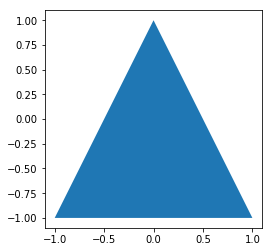

In [6]:
a = np.array([0, 1])
b = np.array([-1, -1])
c = np.array([ 1, -1])
points = np.vstack([a,b,c])
plt.fill(points[:,0], points[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [7]:
arr = [
    [1,2], [1,0,0,1],
    [3,4], [1,0,0,1],
    [5,6], [1,0,0,1],
]

np.array(arr)

array([list([1, 2]), list([1, 0, 0, 1]), list([3, 4]), list([1, 0, 0, 1]),
       list([5, 6]), list([1, 0, 0, 1])], dtype=object)

In [11]:
np.append(np.random.random((3)), 1)

array([0.77264838, 0.05610047, 0.30879311, 1.        ])